In [ ]:
!pip install -q kagglehub

In [ ]:
import kagglehub
path = kagglehub.dataset_download("juliencalenge/felidae-tiger-lion-cheetah-leopard-puma")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/juliencalenge/felidae-tiger-lion-cheetah-leopard-puma/versions/1


In [ ]:
import os

dataset_dir = os.path.join(path, "Felidae")
print("Class:", os.listdir(dataset_dir))

Class: ['Lion', 'Leopard', 'Cheetah', 'Tiger', 'Puma']


In [ ]:
import shutil, random

def prepare_dataset(original_dir, base_output, split_ratio=0.8):
    if not os.path.exists(base_output):
        os.makedirs(base_output)

    train_dir = os.path.join(base_output, "train")
    val_dir = os.path.join(base_output, "val")

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        split = int(len(images) * split_ratio)

        for i, img in enumerate(images):
            target_dir = train_dir if i < split else val_dir
            class_target_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_target_dir, exist_ok=True)

            src = os.path.join(class_path, img)
            dst = os.path.join(class_target_dir, img)
            shutil.copyfile(src, dst)

    return train_dir, val_dir

train_dir, val_dir = prepare_dataset(dataset_dir, "/content/Big Cat Split")

In [ ]:
!pip install -q tensorflow numpy matplotlib pillow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, brightness_range=(0.5, 1.5),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

Found 231 images belonging to 5 classes.
Found 88 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

/tmp/ipython-input-2084538547.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7713 - loss: 0.5124 - val_accuracy: 0.8636 - val_loss: 0.2895
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7611 - loss: 0.6063 - val_accuracy: 0.8977 - val_loss: 0.2113
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8002 - loss: 0.5720 - val_accuracy: 0.8977 - val_loss: 0.2373
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8711 - loss: 0.3700 - val_accuracy: 0.8977 - val_loss: 0.2569
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8536 - loss: 0.3324 - val_accuracy: 0.9091 - val_loss: 0.2054
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8795 - loss: 0.3576 - val_accuracy: 0.9205 - val_loss: 0.2195
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8806 - loss: 0.3750 - val_accuracy: 0.8523 - val_loss: 0.3135
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8410 - loss: 0.3750 - val_accuracy: 0.9205 - val_loss: 0.1680
Epoch 9/

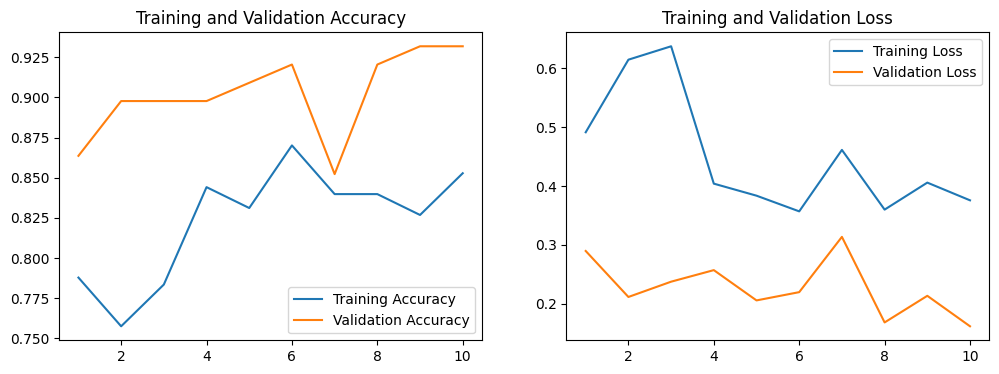

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/sample_data/tiger_wild.webp'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

pred = model.predict(img_array)
predicted_class = np.argmax(pred[0])
class_name = list(train_generator.class_indices.keys())

print("Spesies Terdeteksi:", class_name[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Spesies Terdeteksi: Leopard


In [ ]:
model.save("Felidae.h5")